
# Simulazione di politiche di similarity caching

In [1]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
from PromptDatasetManager import PromptDatasetManager
manager = PromptDatasetManager()

manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=500 # Limita per testare velocemente
)
print(f"Colonne disponibili: {list(manager.df.columns)}")

Colonne disponibili: ['prompt', 'clip_emb', 'user_name', 'timestamp']


## Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used) e TTL (Time To Live) per la gestione della cache.

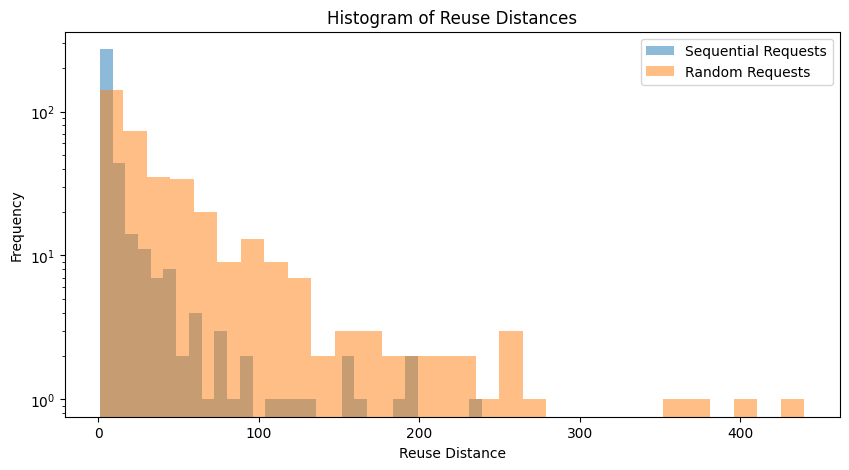

In [3]:

def compute_reuse_dist(requests: List[str], embs: List[np.ndarray], threshold: float = 0.5) -> List[int]:
    last = []
    deltas = []
    for i, emb in enumerate(embs):
        for j in reversed(range(i)):
            dist = np.linalg.norm(emb - embs[j])
            if dist < threshold:
                deltas.append(i - j)
                break  # usa solo la prima occorrenza simile andando indietro
    return deltas


seq_requests = manager.sample_prompts(num_prompts=5000, random_order=False)
rand_requests = manager.sample_prompts(num_prompts=5000, random_order=True)

reuse_seq = compute_reuse_dist(
    [p for p, _ in seq_requests],
    [e for _, e in seq_requests],
    threshold=0.8
)

reuse_rand = compute_reuse_dist(
    [p for p, _ in rand_requests],
    [e for _, e in rand_requests],
    threshold=0.8
)

# Plot histogram of reuse distances (log scale)
plt.figure(figsize=(10, 5))
plt.hist(reuse_seq, bins=30, alpha=0.5, label='Sequential Requests', log=True)
plt.hist(reuse_rand, bins=30, alpha=0.5, label='Random Requests', log=True)
plt.title('Histogram of Reuse Distances')
plt.xlabel('Reuse Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [4]:
import Dashboard as ds
from CachePolicy import LRUCache, LFUCache, TTLCache, RNDLRUCache, RNDTTLCache, TwoLRUCache

In [5]:
from Dashboard import CacheDashboard
from PromptDatasetManager import PromptDatasetManager
from CachePolicy import LFUCache, LRUCache, TTLCache, TwoLRUCache

dashboard = CacheDashboard(
    manager=manager,
    policies=[LFUCache, LRUCache, TTLCache, TwoLRUCache],
    dim=manager.emb_matrix.shape[1],
    num_requests=2000
)

dashboard.show()


BokehModel(combine_events=True, render_bundle={'docs_json': {'2974de31-36a6-4689-92b2-d91069817884': {'version…

### Chaching test

In [6]:
def faiss_search_similarity(
    index: faiss.IndexFlatIP,
    query: np.ndarray,
    topk: int = 10
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Esegue una ricerca di similarità usando FAISS.
    Ritorna le distanze e gli indici dei top-k risultati.
    La ricerca la fa su tutto il dataset indicizzato.
    - index: istanza di faiss.IndexFlatIP indicizzata
    - query: vettore di query (1D o 2D con una riga)
    - topk: numero di risultati da restituire
    """
    query = query.reshape(1, -1).astype(np.float32)
    distances, indices = index.search(query, topk)
    return distances[0], indices[0]

# Create FAISS index from the embedding matrix
dim = manager.emb_matrix.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(manager.emb_matrix.astype(np.float32))

# Stampa le prime 10 similarità per un prompt casuale
prompt, emb = manager.sample_prompts(num_prompts=1, random_order=True)[0]
print(f"Prompt: {prompt}")
distances, indices = faiss_search_similarity(index, emb, topk=10)
print("Top-10 Similarities:")
for i, (dist, idx) in enumerate(zip(distances, indices)):
    if idx == -1:  # -1 indica che non ci sono risultati
        continue
    print(f"{i+1}: {manager.prompts_arr[idx]} (Similarity: {dist:.4f})")
print("Total prompts in index:", len(manager.prompts_arr))


Prompt: doom eternal, game concept art, veins and worms, muscular, chiroptera head, chiroptera ears, shark teeth, ferocious, fierce, hyperrealism, fine details, artstation, cgsociety, zbrush, no background 
Top-10 Similarities:
1: doom eternal, game concept art, veins and worms, muscular, chiroptera head, chiroptera ears, shark teeth, ferocious, fierce, hyperrealism, fine details, artstation, cgsociety, zbrush, no background  (Similarity: 1.0000)
2: doom eternal, game concept art, veins and worms, muscular, chiroptera head, chiroptera ears, shark teeth, ferocious, fierce, hyperrealism, fine details, artstation, cgsociety, zbrush, no background  (Similarity: 1.0000)
3: doom eternal, game concept art, veins and worms, muscular, exoskeleton, chiroptera head, chiroptera ears, shark teeth, ferocious, fierce, hyperrealism, fine details, artstation, cgsociety, zbrush, no background  (Similarity: 0.9950)
4: doom eternal, game concept art, veins and worms, muscular, crustacean exoskeleton, chir

Numero di richieste: 500 (dimensione embedding: (512,))
=== Testing policy: LRUCache ===
=== Summary ===
run_id: a3b5a1cc
policy: LRUTest
hit_rate: 0.566
miss_rate: 0.434
duration: 0.006091594696044922
params: {'capacity': 50, 'threshold': 0.7, 'dim': 512, 'backend': 'faiss_flat'}

Prime richieste registrate:
  event                                                key       sim  \
0  miss  mount epic cobalt war talbuk screenshot world ...      -inf   
1   add  mount epic cobalt war talbuk screenshot world ...       NaN   
2  miss  james graham ballard, highrise, sustainability...  0.474304   
3   add  james graham ballard, highrise, sustainability...       NaN   
4  miss  man in front of a firing squad refuses a cigar...  0.501824   

      timestamp  cache_occupancy  
0  1.753781e+09                0  
1  1.753781e+09                1  
2  1.753781e+09                1  
3  1.753781e+09                2  
4  1.753781e+09                2  


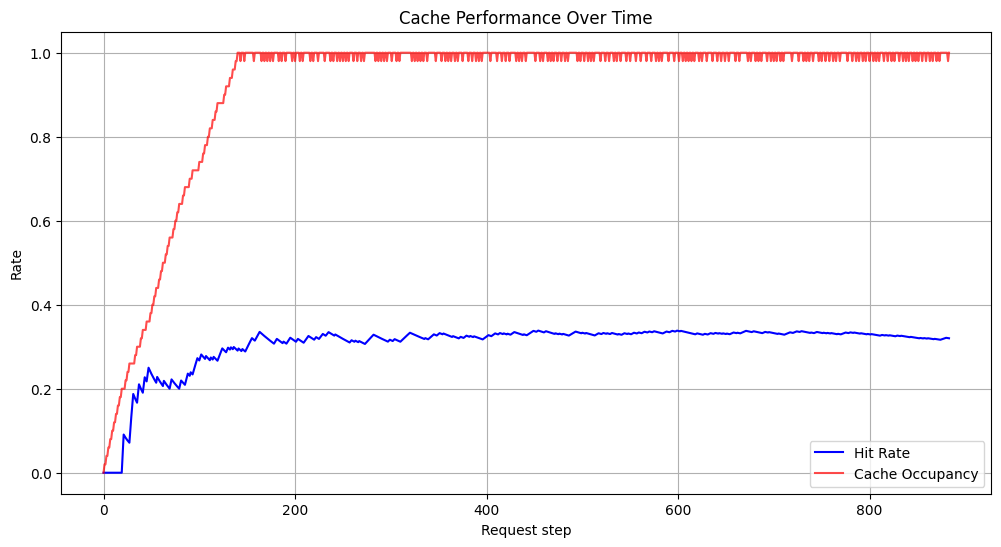

=== Testing policy: LFUCache ===
=== Summary ===
run_id: 69934d2a
policy: LRUTest
hit_rate: 0.566
miss_rate: 0.434
duration: 0.00622105598449707
params: {'capacity': 50, 'threshold': 0.7, 'dim': 512, 'backend': 'faiss_flat'}

Prime richieste registrate:
  event                                                key       sim  \
0  miss  mount epic cobalt war talbuk screenshot world ...      -inf   
1   add  mount epic cobalt war talbuk screenshot world ...       NaN   
2  miss  james graham ballard, highrise, sustainability...  0.474304   
3   add  james graham ballard, highrise, sustainability...       NaN   
4  miss  man in front of a firing squad refuses a cigar...  0.501824   

      timestamp  cache_occupancy  
0  1.753781e+09                0  
1  1.753781e+09                1  
2  1.753781e+09                1  
3  1.753781e+09                2  
4  1.753781e+09                2  


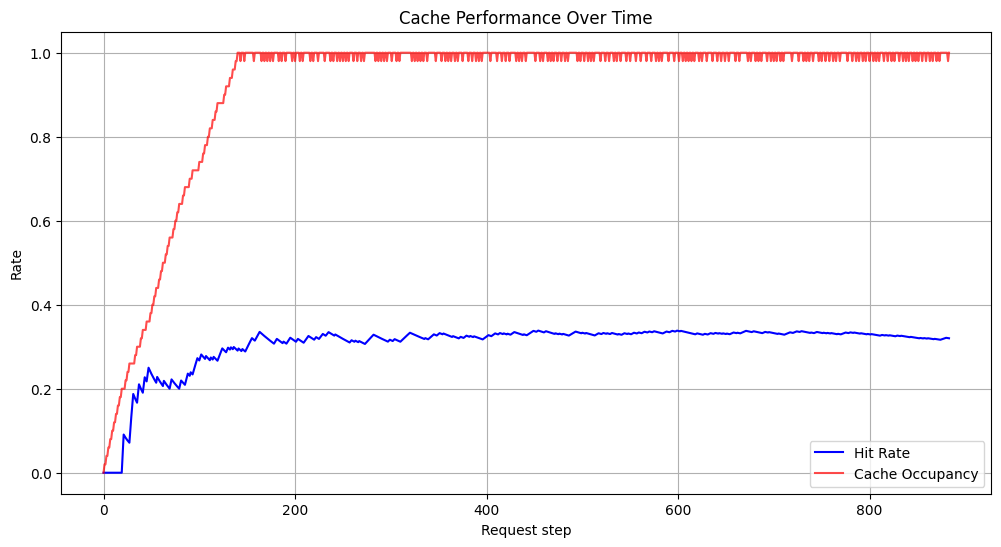

=== Testing policy: TTLCache ===
=== Summary ===
run_id: a197f68a
policy: LRUTest
hit_rate: 0.566
miss_rate: 0.434
duration: 0.006307840347290039
params: {'capacity': 50, 'threshold': 0.7, 'dim': 512, 'backend': 'faiss_flat'}

Prime richieste registrate:
  event                                                key       sim  \
0  miss  mount epic cobalt war talbuk screenshot world ...      -inf   
1   add  mount epic cobalt war talbuk screenshot world ...       NaN   
2  miss  james graham ballard, highrise, sustainability...  0.474304   
3   add  james graham ballard, highrise, sustainability...       NaN   
4  miss  man in front of a firing squad refuses a cigar...  0.501824   

      timestamp  cache_occupancy  
0  1.753781e+09                0  
1  1.753781e+09                1  
2  1.753781e+09                1  
3  1.753781e+09                2  
4  1.753781e+09                2  


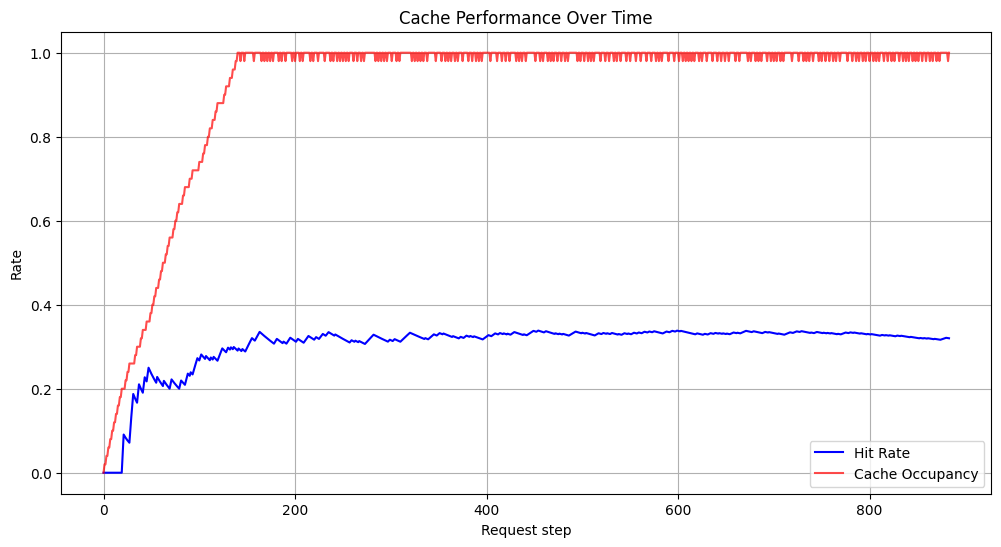

=== Testing policy: RNDLRUCache ===
=== Summary ===
run_id: 9e190e63
policy: LRUTest
hit_rate: 0.566
miss_rate: 0.434
duration: 0.007303953170776367
params: {'capacity': 50, 'threshold': 0.7, 'dim': 512, 'backend': 'faiss_flat'}

Prime richieste registrate:
  event                                                key       sim  \
0  miss  mount epic cobalt war talbuk screenshot world ...      -inf   
1   add  mount epic cobalt war talbuk screenshot world ...       NaN   
2  miss  james graham ballard, highrise, sustainability...  0.474304   
3   add  james graham ballard, highrise, sustainability...       NaN   
4  miss  man in front of a firing squad refuses a cigar...  0.501824   

      timestamp  cache_occupancy  
0  1.753781e+09                0  
1  1.753781e+09                1  
2  1.753781e+09                1  
3  1.753781e+09                2  
4  1.753781e+09                2  


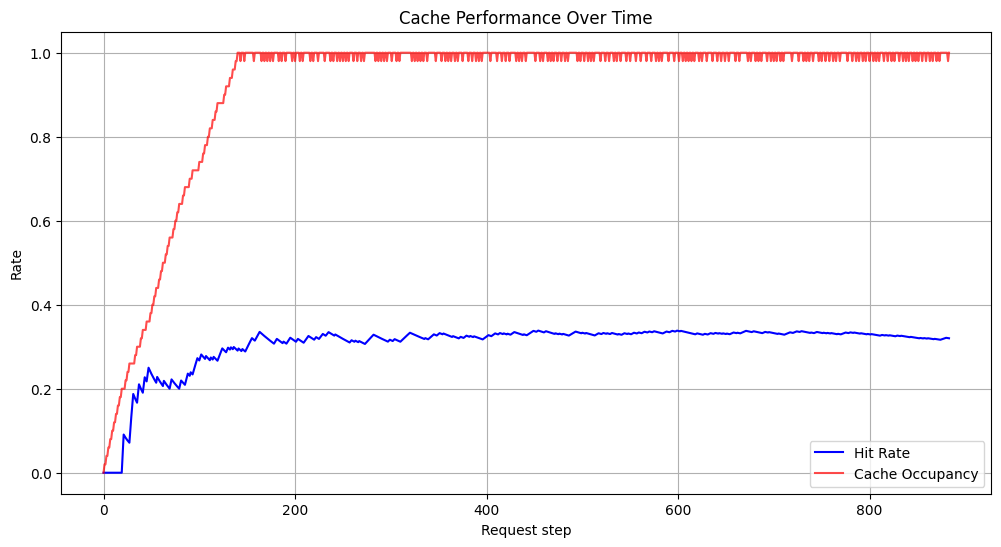

=== Testing policy: RNDTTLCache ===
=== Summary ===
run_id: e49b6965
policy: LRUTest
hit_rate: 0.566
miss_rate: 0.434
duration: 0.006610870361328125
params: {'capacity': 50, 'threshold': 0.7, 'dim': 512, 'backend': 'faiss_flat'}

Prime richieste registrate:
  event                                                key       sim  \
0  miss  mount epic cobalt war talbuk screenshot world ...      -inf   
1   add  mount epic cobalt war talbuk screenshot world ...       NaN   
2  miss  james graham ballard, highrise, sustainability...  0.474304   
3   add  james graham ballard, highrise, sustainability...       NaN   
4  miss  man in front of a firing squad refuses a cigar...  0.501824   

      timestamp  cache_occupancy  
0  1.753781e+09                0  
1  1.753781e+09                1  
2  1.753781e+09                1  
3  1.753781e+09                2  
4  1.753781e+09                2  


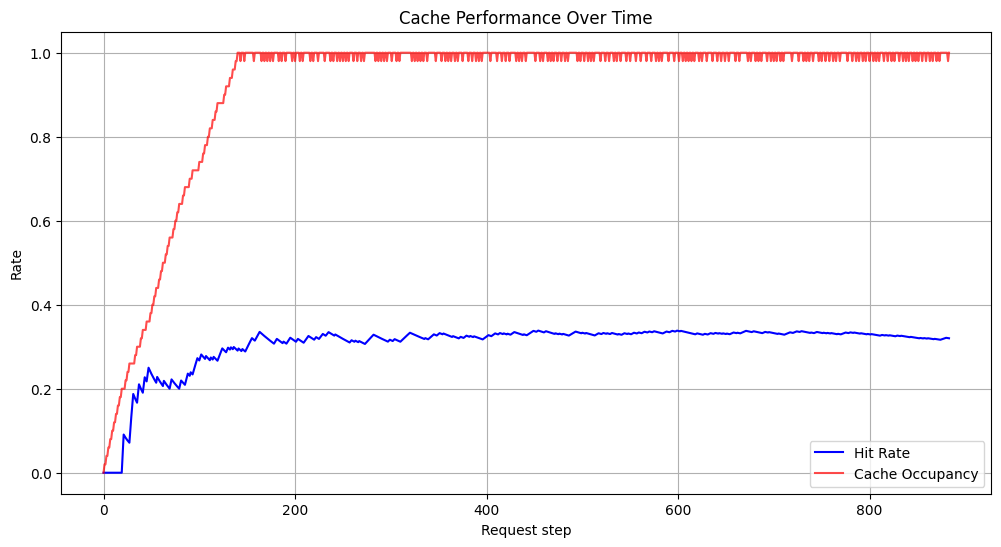

=== Testing policy: TwoLRUCache ===
=== Summary ===
run_id: 99ac94fb
policy: LRUTest
hit_rate: 0.566
miss_rate: 0.434
duration: 0.008662939071655273
params: {'capacity': 50, 'threshold': 0.7, 'dim': 512, 'backend': 'faiss_flat'}

Prime richieste registrate:
  event                                                key       sim  \
0  miss  mount epic cobalt war talbuk screenshot world ...      -inf   
1   add  mount epic cobalt war talbuk screenshot world ...       NaN   
2  miss  james graham ballard, highrise, sustainability...  0.474304   
3   add  james graham ballard, highrise, sustainability...       NaN   
4  miss  man in front of a firing squad refuses a cigar...  0.501824   

      timestamp  cache_occupancy  
0  1.753781e+09                0  
1  1.753781e+09                1  
2  1.753781e+09                1  
3  1.753781e+09                2  
4  1.753781e+09                2  


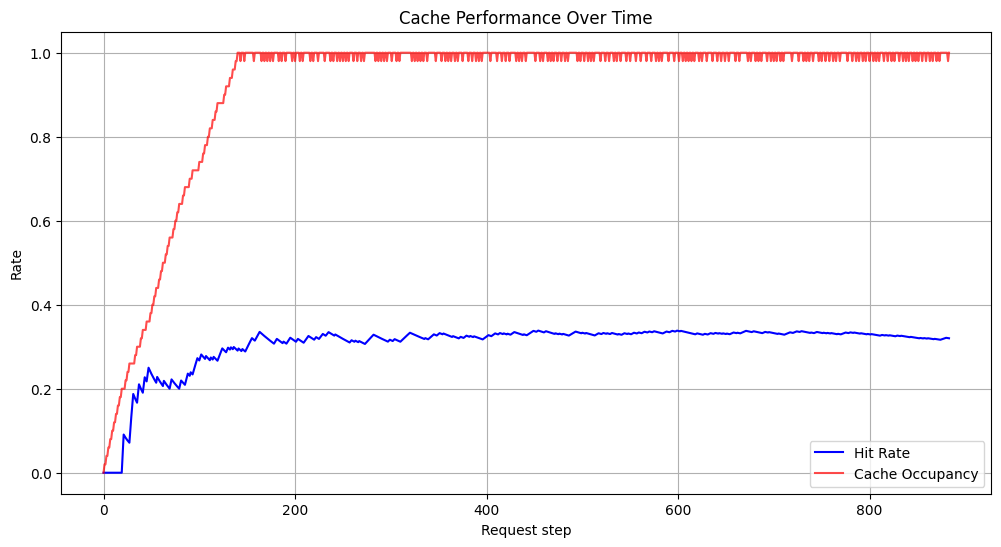

In [7]:
from math import e
from readline import backend
from CachePolicy import LRUCache
from BaseCache import CacheSimulator              # come definito sopra

# === Step 1: Carica dati
N = 500  # per il test: pochi item
promt = manager.sample_prompts(num_prompts=N, random_order=True)
keys, embeddings = zip(*promt)
print(f"Numero di richieste: {len(keys)}"
      f" (dimensione embedding: {embeddings[0].shape})")

# Frequenze stimate (serve per Greedy)
from collections import Counter
lambda_freq = Counter(keys)
lambda_freq = {k: v / N for k, v in lambda_freq.items()}

# === Step 2: Setup cache simulator
sim = CacheSimulator()

# === Step 2: Gui subscribe for update
def subscriber(run_id, event_type, entry):
    print("=== Update received ===")
    print(f"Run ID: {run_id}, Event: {event_type}, Entry: {entry}")

# Registra l'osservatore per gli aggiornamenti
#observer = sim.subscribe_events(subscriber)

for policy in [LRUCache, LFUCache, TTLCache, RNDLRUCache, RNDTTLCache, TwoLRUCache]:
    print(f"=== Testing policy: {policy.__name__} ===")

    run_id = sim.run(
        policy_name="LRUTest",
        policy_class=LRUCache,  # Scegli la politica di cache da testare
        policy_args=dict(
            capacity=50,
            threshold=0.7,
            dim = embeddings[0].shape[0],
            backend = "faiss_flat",
        ),
        embeddings=embeddings,
        keys=keys,
        trace_indices=list(range(N))
    )


    # === Step 3: Risultati
    summary = sim.get_summary(run_id)
    print("=== Summary ===")
    for k, v in summary.items():
        print(f"{k}: {v}")

    # === Step 4: Visualizzazione base
    df = sim.get_history(run_id)
    print("\nPrime richieste registrate:")
    print(df.head())
    
    df['cumulative_hit_rate'] = df['event'].eq('hit').cumsum() / (df.index + 1)
    # Plot hit rate and cache occupancy
    plt.figure(figsize=(12, 6))
    
    # Plot hit rate
    plt.plot(df['cumulative_hit_rate'], label='Hit Rate', color='blue')
    
    # Plot cache occupancy (normalized to 0-1 scale)
    cache_size = summary['params']['capacity']
    cache_occupancy = df['cache_occupancy'] 
    cache_occupancy = cache_occupancy / cache_size if cache_size > 0 else np.zeros_like(cache_occupancy)
    plt.plot(cache_occupancy, label='Cache Occupancy', color='red', alpha=0.7)

    plt.title("Cache Performance Over Time")
    plt.xlabel("Request step")
    plt.ylabel("Rate")
    plt.legend()
    plt.grid(True)
    plt.show()



Benchmarking FAISS_FLAT backend...
FAISS_FLAT | Cache: 10 | Time/query: 0.000007s
FAISS_FLAT | Cache: 1000 | Time/query: 0.000051s
FAISS_FLAT | Cache: 5000 | Time/query: 0.000172s
FAISS_FLAT | Cache: 25000 | Time/query: 0.000838s
FAISS_FLAT | Cache: 75000 | Time/query: 0.002666s
FAISS_FLAT | Cache: 100000 | Time/query: 0.003502s

Benchmarking LINEAR backend...
LINEAR | Cache: 10 | Time/query: 0.000024s
LINEAR | Cache: 1000 | Time/query: 0.000318s
LINEAR | Cache: 5000 | Time/query: 0.001540s
LINEAR | Cache: 25000 | Time/query: 0.007657s
LINEAR | Cache: 75000 | Time/query: 0.023191s
LINEAR | Cache: 100000 | Time/query: 0.031575s


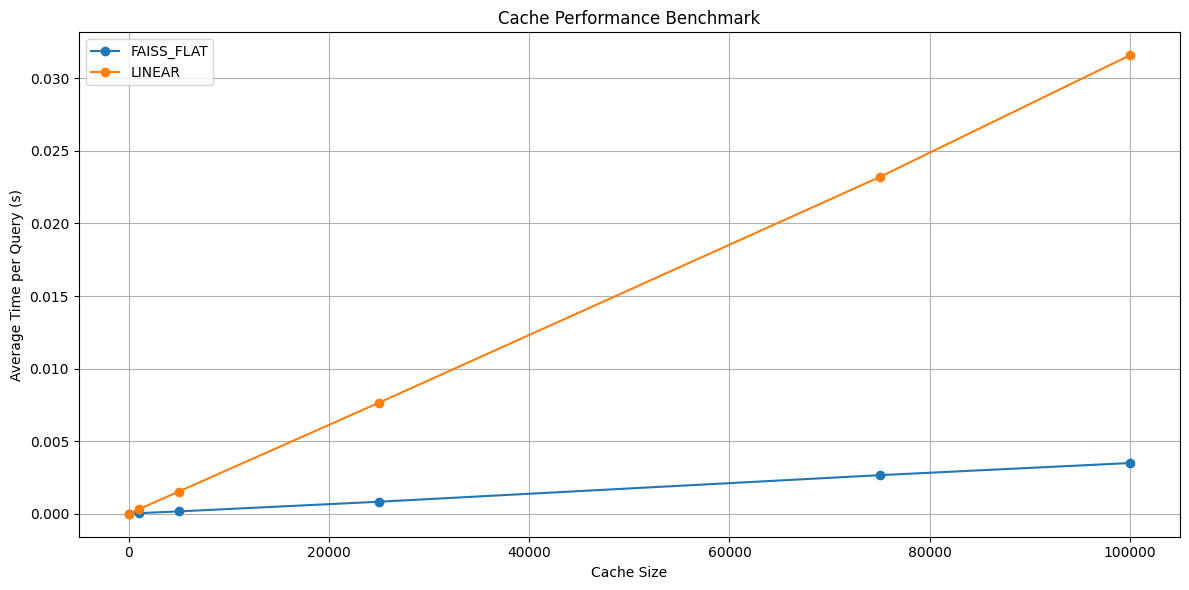

Exception in thread Thread-4 (_run_simulation):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/Users/tella/Workspace/Inria/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tella/Workspace/Inria/Code/Project/Dashboard.py", line 91, in _run_simulation
    run_id = self.simulator.run(
        policy_name=policy_name,
    ...<4 lines>...
        trace_indices=trace_indices
    )
  File "/Users/tella/Workspace/Inria/Code/Project/BaseCache.py", line 100, in run
    cache = policy_class(**policy_args)
TypeError: LFUCache.__init__() got an une

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from BaseCache import BaseSimilarityCache

# Config
DIMS = 512
CACHE_SIZES = [10, 1000, 5000, 25000, 75000, 100000]
N_QUERIES = 100

def simulate_clip_embeddings(n: int) -> np.ndarray:
    vecs = np.random.randn(n, DIMS).astype(np.float32)
    return vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

def benchmark_cache(backend: str):
    avg_times = []
    for size in CACHE_SIZES:
        cache = BaseSimilarityCache(
            capacity=size,
            threshold=0.3,
            dim=DIMS,
            backend=backend  # stringa: "faiss", "linear", "annoy"
        )
        embeddings = simulate_clip_embeddings(size)
        for i in range(size):
            cache.index.add(f"vec_{i}", embeddings[i])

        queries = simulate_clip_embeddings(N_QUERIES)
        start = time.time()
        for i, emb in enumerate(queries):
            cache.query(f"query_{i}", emb)
        end = time.time()

        avg = (end - start) / N_QUERIES
        avg_times.append(avg)
        print(f"{backend.upper()} | Cache: {size} | Time/query: {avg:.6f}s")
    return avg_times

# Esegui i benchmark per i vari backend
backends = ['faiss_flat', 'linear']

results = {}
for backend in backends:
    print(f"\nBenchmarking {backend.upper()} backend...")
    results[backend] = benchmark_cache(backend)
# Plot results
plt.figure(figsize=(12, 6))
for backend, times in results.items():
    plt.plot(CACHE_SIZES, times, marker='o', label=backend.upper())
plt.xscale('linear')
plt.xlabel('Cache Size')
plt.ylabel('Average Time per Query (s)')
plt.title('Cache Performance Benchmark')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()